# <center>PCOS - Initial Analysis To Create A Prediction System</center>

## Introduction

**Polycystic ovary syndrome (PCOS)** is a condition in which the ovaries produce an abnormal amount of male sex hormones.</br> The name of this disease describes the numerous small cysts that form in the ovaries.

The most common sympthoms of PCOS are:

- Irregular periods

- Ovaries that are large or have many cysts

- Excess body hair

- Weight gain

- Acne or oily skin

- Male-pattern baldness or thinning hair

- Infertility 

- Dark or thick skin patches

**Dataset specification**

The dataset comes from the Kaggle platform. Was attached by Karnik Kapoor and contains information from hospital databases. They include all physical and clinical parameters to determine PCOS and infertility related issues. 
</br>Important details:

- Collected from 10 different hospitals across Kerala, India
- The unit used is feet to cm
- Blood pressure entered as systolic and diastolic separately
- RBS means Random glucose test
- Beta-HCG cases are mentioned as Case I and II
- Blood Group indications: A+ = 11, A- = 12, B+ = 13, B- = 14, O+ =15, O- = 16, AB+ =17, AB- = 18

## Load data

### Import all required libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
import warnings
warnings.filterwarnings('ignore')

### Create dataframes

In [2]:
pcos_inf = pd.read_csv('PCOS_infertility.csv')
pcos_without = pd.read_excel('PCOS_without.xlsx', sheet_name="Full_new")

### Merge data

In [3]:
pcos = pd.merge(pcos_without,pcos_inf, on='Patient File No.', suffixes={'','_y'},how='left')

In [4]:
# Number of rows and columns

pcos.shape

(541, 50)

In [5]:
# This is how our dataframe looks like

pcos.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44,Sl. No_y,PCOS (Y/N)_y,I beta-HCG(mIU/mL)_y,II beta-HCG(mIU/mL)_y,AMH(ng/mL)_y
0,1,1,0,28,44.6,152.0,19.300000,15,78,22,...,3,18.0,18.0,8.5,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,0,36,65.0,161.5,24.921163,15,74,20,...,5,15.0,14.0,3.7,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,1,33,68.8,165.0,25.270891,11,72,18,...,15,18.0,20.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,0,37,65.0,148.0,29.674945,13,72,20,...,2,15.0,14.0,7.5,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,0,25,52.0,161.0,20.060954,11,72,18,...,4,16.0,14.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning and preprocessing

In [6]:
# Check column names

pcos.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'],
     

In [7]:
# Drop repeated and unnecessary features

pcos = pcos.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y', "Sl. No", "Patient File No."], axis=1)

In [8]:
# Rename target column and the names of columns that won't be properly changed by the following function

pcos = pcos.rename(columns = {"PCOS (Y/N)":"Target", "Follicle No. (L)":"follicle_no_l",
                              "Follicle No. (R)":"follicle_no_r","Avg. F size (L) (mm)":"avg_fsize_l",
                              "Avg. F size (R) (mm)":"avg_fsize_r"})

In [9]:
# Get rid of unwanted characters and simplify column names

import re

def clean_col(col):
    col = re.sub("\(.*?\)","", col)
    col = col.strip()
    col = col.replace(" ","_")
    col = col.replace("__","")
    col = col.replace(".","")
    col = col.replace("-","_")
    col = col.lower()
    return col

pcos.columns = [clean_col(i) for i in pcos.columns]

In [10]:
# Recent fixes

pcos = pcos.rename(columns = {"waist:hip_ratio":"hip_ratio","regexercise":"reg_exercise","bpsystolic":"bp_systolic",
                             "bpdiastolic":"bp_diastolic"})

In [11]:
# Column names after cleaning

pcos.columns

Index(['target', 'age', 'weight', 'height', 'bmi', 'blood_group', 'pulse_rate',
       'rr', 'hb', 'cycle', 'cycle_length', 'marraige_status', 'pregnant',
       'no_of_aborptions', 'i_beta_hcg', 'iibeta_hcg', 'fsh', 'lh', 'fsh/lh',
       'hip', 'waist', 'hip_ratio', 'tsh', 'amh', 'prl', 'vit_d3', 'prg',
       'rbs', 'weight_gain', 'hair_growth', 'skin_darkening', 'hair_loss',
       'pimples', 'fast_food', 'reg_exercise', 'bp_systolic', 'bp_diastolic',
       'follicle_no_l', 'follicle_no_r', 'avg_fsize_l', 'avg_fsize_r',
       'endometrium'],
      dtype='object')

In [12]:
# List the types of values in columns

pcos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            541 non-null    int64  
 1   age               541 non-null    int64  
 2   weight            541 non-null    float64
 3   height            541 non-null    float64
 4   bmi               541 non-null    float64
 5   blood_group       541 non-null    int64  
 6   pulse_rate        541 non-null    int64  
 7   rr                541 non-null    int64  
 8   hb                541 non-null    float64
 9   cycle             541 non-null    int64  
 10  cycle_length      541 non-null    int64  
 11  marraige_status   540 non-null    float64
 12  pregnant          541 non-null    int64  
 13  no_of_aborptions  541 non-null    int64  
 14  i_beta_hcg        541 non-null    float64
 15  iibeta_hcg        541 non-null    object 
 16  fsh               541 non-null    float64
 1

In [13]:
# Type correction

pcos["iibeta_hcg"] = pd.to_numeric(pcos["iibeta_hcg"], errors='coerce')
pcos["amh"] = pd.to_numeric(pcos["amh"], errors='coerce')

In [14]:
# Check the data for missing values

pcos.isnull().sum()

target              0
age                 0
weight              0
height              0
bmi                 0
blood_group         0
pulse_rate          0
rr                  0
hb                  0
cycle               0
cycle_length        0
marraige_status     1
pregnant            0
no_of_aborptions    0
i_beta_hcg          0
iibeta_hcg          1
fsh                 0
lh                  0
fsh/lh              0
hip                 0
waist               0
hip_ratio           0
tsh                 0
amh                 1
prl                 0
vit_d3              0
prg                 0
rbs                 0
weight_gain         0
hair_growth         0
skin_darkening      0
hair_loss           0
pimples             0
fast_food           1
reg_exercise        0
bp_systolic         0
bp_diastolic        0
follicle_no_l       0
follicle_no_r       0
avg_fsize_l         0
avg_fsize_r         0
endometrium         0
dtype: int64

In [15]:
# Deal with missing values

pcos["marraige_status"].fillna(pcos["marraige_status"].median(),inplace=True)
pcos["iibeta_hcg"].fillna(pcos["iibeta_hcg"].median(),inplace=True)
pcos["amh"].fillna(pcos["amh"].median(),inplace=True)
pcos["fast_food"].fillna(pcos["fast_food"].median(),inplace=True)

## Relationships assessment

In [16]:
# Correlation of features with target

cormat = pcos.corr()
cormat['target'].sort_values(ascending=False)

target              1.000000
follicle_no_r       0.648327
follicle_no_l       0.603346
skin_darkening      0.475733
hair_growth         0.464667
weight_gain         0.441047
cycle               0.401644
fast_food           0.376183
pimples             0.286077
amh                 0.264141
weight              0.211938
bmi                 0.199534
hair_loss           0.172879
waist               0.164598
hip                 0.162297
avg_fsize_l         0.132992
endometrium         0.106648
avg_fsize_r         0.097690
pulse_rate          0.091821
hb                  0.087170
vit_d3              0.085494
height              0.068254
reg_exercise        0.065337
lh                  0.063879
rbs                 0.048922
bp_diastolic        0.038032
rr                  0.036928
blood_group         0.036433
iibeta_hcg          0.012760
hip_ratio           0.012386
bp_systolic         0.007942
prl                 0.005143
tsh                -0.010140
fsh/lh             -0.018336
pregnant      

- As expected, features containing the number of follicle are the most strongly correlated
- Skin darkening, hair growth, weight gain and cycle type - fairly high correlations; also the most common symptoms of PCOS

## Short exploratory data analysis

### Contents

- Data balance
- Cycle feature analysis
- Distribution of selected variables

In [17]:
# Plots centering

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [18]:
sns.set_palette("Set2")

### Data balance

In [19]:
(pcos['target'].value_counts())


0    364
1    177
Name: target, dtype: int64

[Text(0, 0, '364'), Text(0, 0, '177')]

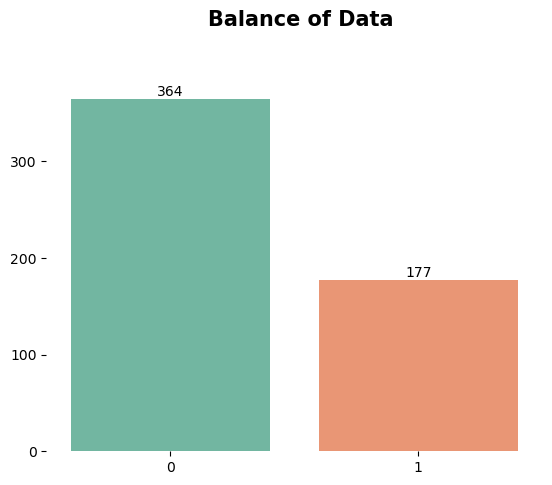

In [20]:
balance_plot = sns.countplot(x='target', data=pcos)
balance_plot.spines[['top','right','bottom','left']].set_visible(False)
balance_plot.text(x=0.15, y=440, s='Balance of Data',
        size=15, weight='bold')
balance_plot.set_yticks([0, 100, 200, 300])
balance_plot.set(ylabel=None, xlabel=None)
balance_plot.bar_label(balance_plot.containers[0])

- Ratio 2:1
- Imbalanced data
- Can cause that the machine learning classifier will be more biased towards the majority class causing the minority class to be misclassified

### Cycle feature

In [21]:
(pcos.groupby('target')['cycle'].value_counts())

target  cycle
0       2        308
        4         56
1       4         94
        2         82
        5          1
Name: cycle, dtype: int64

In [22]:
# Found the wrong value "5" in cycle, so delete it.

pcos.drop(pcos[pcos['cycle'] == 5].index, inplace=True)

Text(-0.72, 380, 'The Number of Times a Given Cycle Type Occurs')

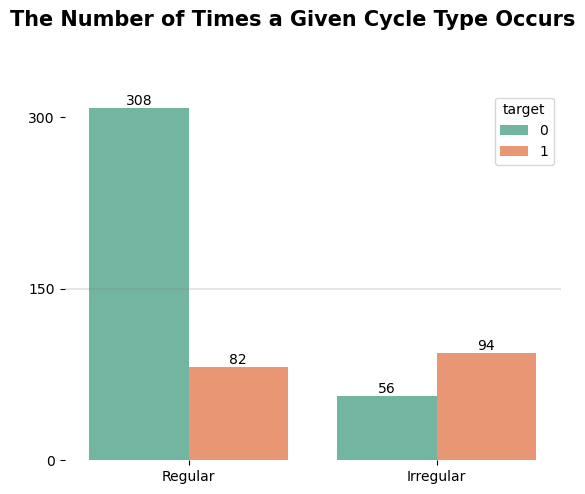

In [23]:
# Plot

cycle_plot = sns.countplot(data=pcos,x='cycle',hue='target')
cycle_plot.bar_label(cycle_plot.containers[0])
cycle_plot.bar_label(cycle_plot.containers[1])
cycle_plot.set_xticklabels(['Regular','Irregular'])
cycle_plot.set_yticks([0, 150, 300])
cycle_plot.set(xlabel=None, ylabel=None)
cycle_plot.spines[['top','right','bottom','left']].set_visible(False)
cycle_plot.axhline(y = 150, color = 'grey', linestyle = '-', alpha=0.2)
cycle_plot.text(x=-0.72, y=380, s='The Number of Times a Given Cycle Type Occurs',
        size=15, weight='bold')

- We have data on 390 people with regular cycles and 150 with irregular cycles
- There is a visible effect of the presence of PCOS on the regularity of the menstrual cycle, with a higher proportion of people with PCOS having irregular cycles (94 out of 176, 53.4%) compared to those without PCOS (56 out of 364, 15.4%)
- A significant number of people with PCOS still have regular cycles (82 out of 176, 46.6%)

### Follicile number vs PCOS

Text(0.5, 0.98, 'Follicle Count vs Target')

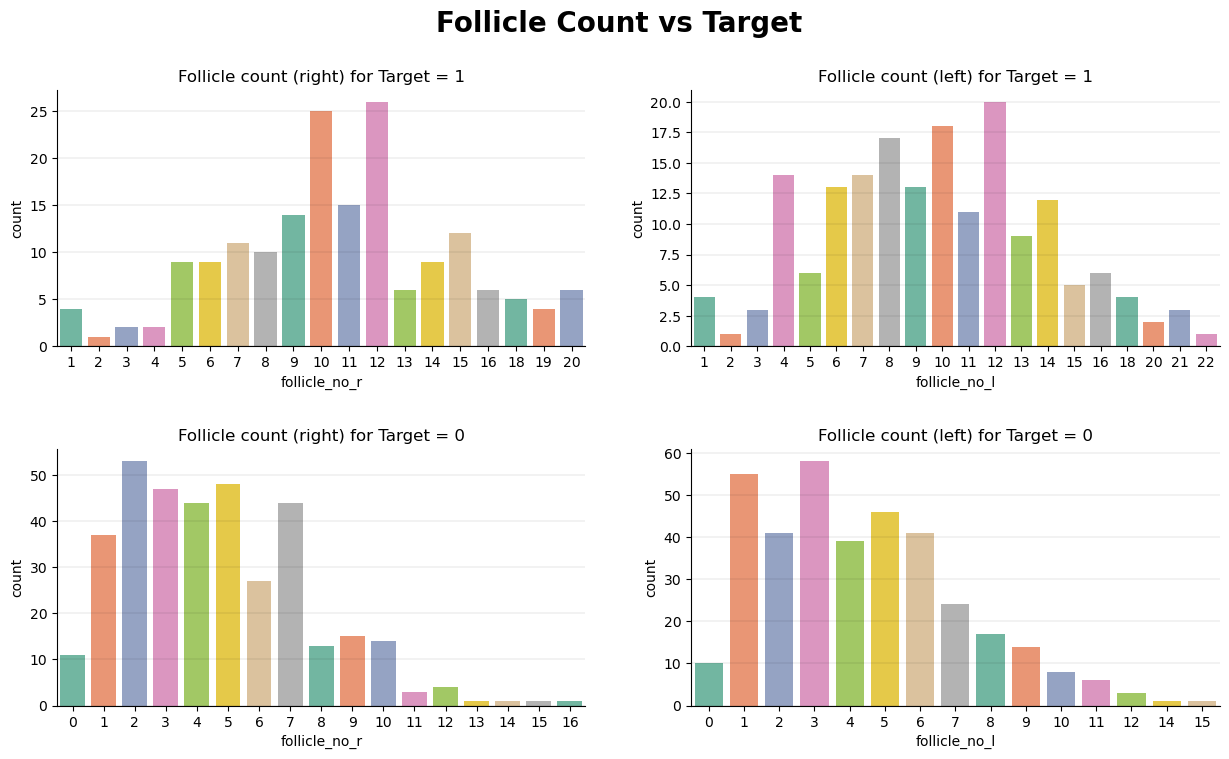

In [24]:
# Chart: target vs number of follicles

fig, axs = plt.subplots(2, 2, figsize=(15,8))

a = pcos.loc[pcos['target'] == 1]["follicle_no_r"]
g1 = sns.countplot(x=a, ax=axs[0, 0], palette="Set2")
g1.spines[['top','right']].set_visible(False)
g1.grid(b=True, color='black', linewidth=0.075, axis='y')
axs[0, 0].set_title("Follicle count (right) for Target = 1")

b = pcos.loc[pcos['target'] == 1]["follicle_no_l"]
g2 = sns.countplot(x=b, ax=axs[0, 1], palette="Set2")
g2.spines[['top','right']].set_visible(False)
g2.grid(b=True, color='black', linewidth=0.075, axis='y')
axs[0, 1].set_title("Follicle count (left) for Target = 1")

c = pcos.loc[pcos['target'] == 0]["follicle_no_r"]
g3 = sns.countplot(x=c, ax=axs[1, 0], palette="Set2")
g3.spines[['top','right']].set_visible(False)
g3.grid(b=True, color='black', linewidth=0.075, axis='y')
axs[1, 0].set_title("Follicle count (right) for Target = 0")

d = pcos.loc[pcos['target'] == 0]["follicle_no_l"]
g4 = sns.countplot(x=d, ax=axs[1, 1], palette="Set2")
g4.spines[['top','right']].set_visible(False)
g4.grid(b=True, color='black', linewidth=0.075, axis='y')
axs[1, 1].set_title("Follicle count (left) for Target = 0")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
fig.suptitle("Follicle Count vs Target", size=20, weight='bold')

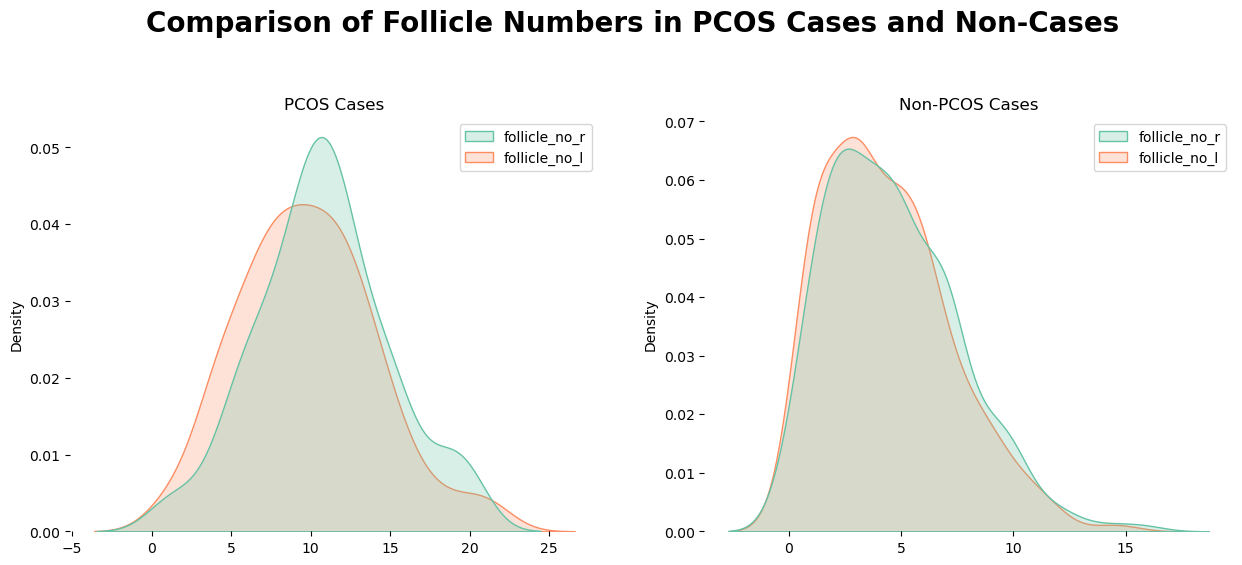

In [25]:
# Density plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

a = pcos.loc[pcos['target'] == 1][["follicle_no_r", "follicle_no_l"]]
sns.kdeplot(data=a, ax=ax1, shade=True)
sns.despine(left=True, bottom=True)
ax1.set_title("PCOS Cases")

b = pcos.loc[pcos['target'] == 0][["follicle_no_r", "follicle_no_l"]]
sns.kdeplot(data=b, ax=ax2, shade=True)
sns.despine(left=True, bottom=True)
ax2.set_title("Non-PCOS Cases")

fig.suptitle("Comparison of Follicle Numbers in PCOS Cases and Non-Cases", size=20, weight='bold')
fig.subplots_adjust(top=0.8)

**Consistent with the previously shown relationship between the number of follicles and PCOS, the following relationships can be observed in the graphs and the following conclusions can be drawn:**

- The more follicles, the greater the risk of developing PCOS
- The number of follicles is an important risk factor for PCOS
- Monitoring the number of follicles can help detect PCOS

...

## Model building

### Algorithms

We will compare the following machine learning algorithms:

- Logistic Regression
- KNN
- Decision Tree
- SVM
- Random Forest
- XGBRF
- CatBoost

### Metric

Probably, the best choice will be to use the **precision-recall curve** and **area under curve (PR AUC)**. This will optimize both precision and recall across all thresholds. Additionally, the **ROC curve** and the **area under the curve (ROC AUC)** can be taken into account. This will maximize the true positive rate and minimize the false positive rate.

### Train-Test Split

In [26]:
X = pcos.drop(labels = ["target"],axis = 1)
y = pcos.target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Hyperparameter Tuning and Cross Validation

In [67]:
random_state = 42

classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state, max_iter=1000000),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : np.arange(10,500,10),
                "max_depth": np.arange(1,20,2)}

svc_param_grid = {"kernel" : ["poly", "rbf"],
                 "gamma": [0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[100,300,500,1000],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

logreg_param_grid = {"C":np.logspace(-3,3,7)}

knn_param_grid = {"n_neighbors": np.arange(1,20,2),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}

classifier_param = [dt_param_grid, svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [78]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10),
                       scoring = "average_precision", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(round(clf.best_score_*100,2))
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 490 candidates, totalling 4900 fits
75.13
Fitting 10 folds for each of 42 candidates, totalling 420 fits
78.37
Fitting 10 folds for each of 96 candidates, totalling 960 fits
93.06
Fitting 10 folds for each of 7 candidates, totalling 70 fits
90.07
Fitting 10 folds for each of 40 candidates, totalling 400 fits
62.62


### Best estimators

In [71]:
best_estimators

[DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=42),
 SVC(C=1, gamma=0.01, kernel='poly', random_state=42),
 RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=1000,
                        random_state=42),
 LogisticRegression(max_iter=1000000, random_state=42),
 KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights='distance')]

In [72]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

### XGBRF and CatBoost Classsifier

Training PR: % 91.53
Testing PR: % 86.42


### Results